# Load and visualize the data

We used Google colab for this baseline experiment. First upload the training_dataset.zip archive to google drive. (https://drive.google.com/file/d/1DMxKpqAaCvl8HerptL11VeUZVjKSUzYJ/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Please replace the path below with the path to your project folder
!ls drive/MyDrive/Deep_Learning_Project_28/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
training_dataset_old  training_dataset.zip


## Unzip

In [1]:
!unzip "drive/MyDrive/Deep_Learning_Project_28/training_dataset.zip" -d "drive/MyDrive/Deep_Learning_Project_28/"

## Number of observations

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

from skimage.io import imread
from skimage.transform import resize

In [ ]:
def set_paths(drive_path) :

    image_paths = sorted(glob.glob(drive_path + "data/*.tiff"))
    label_paths = sorted(glob.glob(drive_path + "labels/*.tif"))
    dir_img = drive_path + 'data/'
    dir_mask = drive_path + 'labels/'
    dir_checkpoint = Path('./checkpoints/')
    print("Total Observations:\t", 'images', len(image_paths), ', labels', len(label_paths))

    return image_paths, label_paths, dir_img, dir_mask, dir_checkpoint

drive_path =  'drive/MyDrive/Deep_Learning_Project_28/training_dataset/'
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)
print("Total Observations:\t", 'images', len(image_paths), ', labels', len(label_paths))


Total Observations:	 images 500 , labels 500
Total Observations:	 images 500 , labels 500


## Visualization

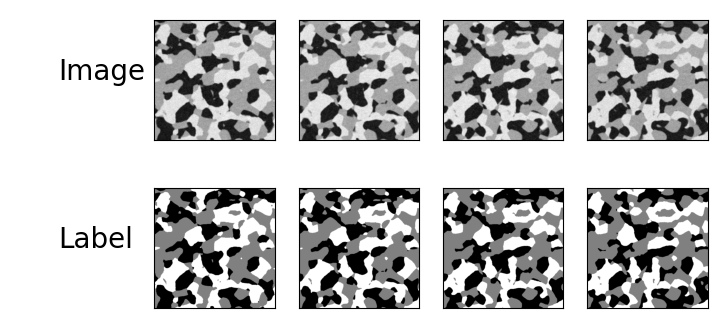

In [ ]:
# Display the first image and its segmentation
f, axarr = plt.subplots(2, 5, subplot_kw={'xticks': [], 'yticks': []}, figsize=(9, 4))

axarr[0,0].text(0.4, 0.5, 'Image', fontsize=20)
axarr[0,0].axis('off')
axarr[0,0].set_clip_on(False)


axarr[1,0].text(0.4, 0.5, 'Label', fontsize=20)
axarr[1,0].axis('off')
axarr[1,0].set_clip_on(False)

for i in range(4):
  image = imread(image_paths[i*4], as_gray=True)
  axarr[0,i+1].imshow(image, cmap='gray')

  label = imread(label_paths[i*4], as_gray=True)
  axarr[1,i+1].imshow(label, cmap='gray')

plt.show()

## Class encoding

From the label images of the previous cell we see that the classes are encoded as grayscale images of three shades.

This means there is one color channel.

In [ ]:
label = imread(label_paths[0], as_gray=True)
print(label.shape)

(501, 501)


 And three pixel values (0, 128, 255) representing the three classes. The following cell counts the number of pixel with each value in a label image.

In [ ]:
unique, counts = np.unique(label, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 79317]
 [  128 89810]
 [  255 81874]]


# U-net model

## Definition for multiclass segmentation adapted from https://github.com/milesial/Pytorch-UNet and https://github.com/hamdaan19/UNet-Multiclass

Input: grayscale image (501x501)

Output: 3-channel masks containing the logits (501x501x3)

### U-net parts:

(https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)

*   DoubleConv
*   Down
*   Up
*   OutConv



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### U-net model assembly

(https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py)

In [ ]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Dataset loading utils

(https://github.com/milesial/Pytorch-UNet/blob/master/utils/data_loading.py)

## Change to adapt the dataset

Rename images and labels so they are compatible with BasicDataset.

The Carvana dataset has image, mask pairs of image:0cdf5b5d0ce1_11, mask:0cdf5b5d0ce1_11_mask (https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview).

Our dataset has image, mask pairs of image: SOCprist0025, label: slice_025.

We rename all files and keep only the ids (e.g. 025)

In [ ]:
from os.path import splitext, isfile, join

# Images
def rename_images(image_paths,drive_path ):
    for index, path in enumerate(image_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "data/" + id + ".tiff")
        os.rename(path, drive_path + "data/" + id + ".tiff")

# Labels
def rename_labels(label_paths,drive_path ):
    for index, path in enumerate(label_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "labels/" + id + ".tif")
        os.rename(path, drive_path + "labels/" + id + ".tif")

In [2]:
rename_images(image_paths = image_paths,drive_path = drive_path)
rename_labels(label_paths = label_paths,drive_path =drive_path)

In [ ]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = load_image(mask_file[0])
        img = load_image(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)
        mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, images_dir, mask_dir, scale=1):
        super().__init__(images_dir, mask_dir, scale, mask_suffix='_mask')

# Dice loss

In [ ]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

# Evaluation

Using multiclass dice score

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# from utils.dice_score import multiclass_dice_coeff, dice_coeff


@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

# Training


Installing wandb to track our training and results.

In [3]:
!pip3 install wandb

In [ ]:
import wandb
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    # 1. Create dataset
    try:
        # dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = 100
    n_train = 400
    n_total = n_val + n_train
    smaller_set, _ = random_split(dataset, [n_total, int(len(dataset))-n_total], generator=torch.Generator().manual_seed(0))
    train_set, val_set = random_split(smaller_set, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()

## Change in args

Bypass `get_args()` by populating the args object manually with values that are relevant to our application.

In [ ]:
class ArgsBypass:
  epochs  = 5
  batch_size  = 1
  lr = 1e-5
  load = False
  scale = 1
  val = 10.0
  amp = False
  bilinear = False
  classes = 3
  pass

args = ArgsBypass()

Please use the wandb run link logged at the beginning of training to track the progress of the run.

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
# model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = UNet(n_channels=1, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
              f'\t{model.n_channels} input channels\n'
              f'\t{model.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                  'Enabling checkpointing to reduce memory usage, but this slows down training. '
                  'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp
    )

100%|██████████| 500/500 [00:09<00:00, 54.64it/s]


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
learning rate,██████████████████▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation Dice,▁▄▅▅▆▅▅▇█▆█▇███▇█████████
epoch,5
learning rate,0.0
step,2250
train loss,0.02967
validation Dice,0.98896


Epoch 5/5: 100%|██████████| 400/400 [02:55<00:00,  2.28img/s, loss (batch)=0.0403]


# Revert the data names change so the notebooks can be run indepentently of each other.


In [ ]:
def add_prefix_to_files(folder_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/labels/' , prefix ="slice__"):
    """
    Add a prefix to the beginning of all files in the specified folder.

    Parameters:
    - folder_path: Path to the folder containing the files.
    - prefix: The prefix to add to each filename.
    """

    # List all files in the folder
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)

        # Construct the new filename with the added prefix
        new_file_name = prefix + file_name

        # Construct the full path to the new file
        new_file_path = os.path.join(folder_path, new_file_name)

        # Rename the file with the new filename
        os.rename(file_path, new_file_path)

add_prefix_to_files(folder_path = drive_path + "labels/" , prefix ="slice__")
add_prefix_to_files(folder_path = drive_path + "data/" , prefix ="SOCprist0")